# Simple Recurrent Model

Using the class-balanced data.

# Imports and Setup

Common imports and standardized code for importing the relevant data, models, etc., in order to minimize copy-paste/typo errors.


Set the relevant text field (`'abstract'` or `'title'`) and whether we are working with `'one-hot'` or `'tokenized'` text.  

Raw data was prepared with a max of 256 words for abstracts and 16 for titles. The insertion of spaces around punctuation increases the effective word count, and exploration shows that nearly all of the data is captured by increasing the SEQ_LEN by 50%.

In [1]:
TEXT_FIELD = 'title'
TEXT_ENCODING = 'one-hot'
assert TEXT_FIELD in ('abstract', 'title'), 'TEXT_FIELD must be one of "title" or "abstract".'
assert TEXT_ENCODING in ('one-hot', 'tokenized'), 'TEXT_ENCODING must be one of "one-hot" or "tokenized".'
# The above choices determine the relevant sequence length of the data.
if TEXT_ENCODING == 'one-hot':
    SEQ_LEN = 128 if TEXT_FIELD == 'title' else 2048
else:
    SEQ_LEN = int(1.5 * 16) if TEXT_FIELD == 'title' else int(1.5 * 256)

Imports and colab setup

In [2]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import seaborn as sns
import torch
import wandb

`wandb` log in:

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Google drive access

In [4]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import my models, loaders, and utility functions:

In [5]:
import arxiv_vixra_models as avm

Set the model, datamodule, and text utils to be instantianted in the notebook

In [6]:
notebook_model = avm.LitOneHotCharRNNAV
notebook_datamodule = avm.OneHotCharDataModuleAV
notebook_encoder = avm.one_hot_encoding 
notebook_decoder = avm.one_hot_decoding 
notebook_wandb_callback = avm.WandbAVPredictionCallback

Copy data to cwd for speed.

In [7]:
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
if TEXT_ENCODING == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
elif TEXT_FIELD == 'abstract':
    tokens_file_name = 'balanced_abstract_normalized_vocab.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{tokens_path}' .
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
tokens_df = pd.read_feather(tokens_file_name)
if TEXT_ENCODING == 'one-hot':
    text_to_idx = dict(zip(tokens_df.char.values, np.arange(len(tokens_df))))
else:
    # 0 and 1 are reserved for padding and <UNK> for embeddings and not included
    # in tokens_df
    text_to_idx = dict(zip(tokens_df.word.values, np.arange(2, len(tokens_df) + 2)))
    text_to_idx['<PAD>'] = 0
    text_to_idx['<UNK>'] = 1
idx_to_text = {val: key for key, val in text_to_idx.items()}

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [8]:
# GPU. Save availability to IS_CUDA_AVAILABLE.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  IS_CUDA_AVAILABLE = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  IS_CUDA_AVAILABLE = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
NUM_PROCESSORS = cpu_count()

GPU
--------------------------------------------------
 Fri Jan 14 16:34:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel. The `entity` needed for various `wandb` calls is just the `wandb` user name.

In [9]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)
ENTITY = 'garrett361'

balanced_title_recurrent_one_hot


# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [ ]:
val_data_intersections_filtered_df = val_data_df.merge(train_data_df, on=[TEXT_FIELD], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_data_df) - len(val_data_intersections_filtered_df)} items removed from val set, {100 * (len(val_data_df) - len(val_data_intersections_filtered_df)) / len(val_data_df):.3f} percent.')

42 items removed from val set, 0.558 percent.


Inspect datasets using `print` and `to_string()` to avoid colab javascript errors

In [ ]:
print(train_data_df.head().to_string())

                                                                                                title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
print(val_data_intersections_filtered_df.head().to_string())

                                                                                                          title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [ ]:
model_args_dict = {'seq_len': SEQ_LEN,
                  'tokens': tokens_df,
                  'num_layers': 2,
                  'hidden_size': 512,
                  'rnn_type': 'GRU',
                  'bidirectional': True,
                  'hidden_strategy': 'mean',
                  'fc_dims': None,
                  'zero_fc_bias_init': True,
                  'lr_scheduler': 'plateau',
                  'lr_scheduler_args': {'verbose': True,
                                        'patience': 1,
                                        'factor': .1}
                  }

data_args_dict = {'seq_len': SEQ_LEN,
                 'train_data': train_data_df,
                 'val_data': val_data_intersections_filtered_df,
                 'tokens': tokens_df, 
                 'text_column': TEXT_FIELD,
                 'num_workers': NUM_PROCESSORS,
                 'batch_size': 128,
                 'pin_memory': IS_CUDA_AVAILABLE,
                 'persistent_workers': True
                 }

Small test run.

In [ ]:
small_data_module = notebook_datamodule(**{**data_args_dict, **{'sample_size': .5}})
small_data_module.setup()
small_loader = small_data_module.train_dataloader()
small_inputs, small_targets = next(iter(small_loader))
# Print the first few input texts
for tensor, source in zip(small_inputs[:3], small_targets[:3]):
    stripped_text = notebook_decoder(tensor, idx_to_text).strip()
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
small_model = notebook_model(**model_args_dict)
print('Model layers:', small_model)
small_preds, small_losses, _ = small_model.scores_loss_hiddens(small_inputs, small_targets)
print('\npreds shape:', small_preds.shape)
print('\nactual loss:', small_losses.item())
print('\nexpected approx loss', np.log(2.))

text: goodness - of - fit analysis of radial velocities surveys
len: 57
source: False
text: logarithmic elliptic equation and change of universe
len: 52
source: True
text: reducing post - surgery recovery bed occupancy with a probabilistic forecast model
len: 82
source: False


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.



Model layers: LitOneHotCharRNNAV(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (rnn): GRU(69, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1, bias=True)
  )
)

preds shape: torch.Size([1

In [ ]:
# pl implements gradient clipping through the Trainer.
small_trainer = Trainer(gpus=-1 if IS_CUDA_AVAILABLE else 0,
                        max_epochs=1,
                        gradient_clip_val=1
                        )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


A `LR finder stopped early due to diverging loss.` here may be due to having too large a batch size, i.e., not enough samples from the datamodule; [see this github discussion](https://github.com/PyTorchLightning/pytorch-lightning/issues/5044)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_64da1906-372b-456b-ab31-f68e115ec517.ckpt


Suggested lr: 0.00033113112148259105


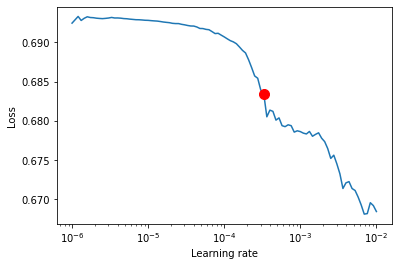

In [ ]:
small_trainer_lr_finder = small_trainer.tuner.lr_find(small_model.to(torch.device('cuda')), datamodule=small_data_module, min_lr=1e-6, max_lr=1e-2)
small_trainer_lr_finder_plot = small_trainer_lr_finder.plot(suggest=True)
small_trainer_suggested_lr = small_trainer_lr_finder.suggestion()
print(f'Suggested lr: {small_trainer_suggested_lr}')

In [ ]:
small_trainer.fit(small_model, datamodule=small_data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type       | Params
--------------------------------------------------
0 | train_metrics_dict | ModuleDict | 0     
1 | val_metrics_dict   | ModuleDict | 0     
2 | test_metrics_dict  | ModuleDict | 0     
3 | rnn                | GRU        | 6.5 M 
4 | fc_layers          | ModuleList | 1.0 K 
--------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
26.067    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.



# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `sweep_fixed_model_args_dict`.
* The hyperparameters chosen by `wandb` from `sweep_config` are merged with those from `sweep_fixed_model_args_dict` and passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.
* Pass a `count: int` arg to `wandb.agent` to limit the number of models trained. Without, the training runs indefinitely.

In [ ]:
sweep_fixed_model_args_dict = {**deepcopy(model_args_dict), 
                               **{'save_models_to_wandb': True}}

sweep_config = {'method': 'random'}
sweep_config['parameters'] =  {'lr': {'distribution': 'log_uniform',
                                      'min': np.log(small_trainer_suggested_lr / 2.).item(),
                                      'max': np.log(small_trainer_suggested_lr * 2.).item()
                                      },
                               'l2_reg': {'distribution': 'log_uniform',
                                              'min': np.log(1e-3).item(),
                                              'max': np.log(1e-1).item(),},
                               'fc_dropout': {'distribution': 'uniform',
                                              'min': .1,
                                              'max': .5}
                               }

Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `sweep_fixed_model_args_dict` for logging purposes.

In [ ]:
# Setting 'batch_size' in sweep_data_args_dict controls the batch size, while setting
# this key in sweep_fixed_model_args_dict just lets wandb track this hyperparameter.
sweep_data_args_dict = deepcopy(data_args_dict)
sweep_data_args_dict['batch_size'] = sweep_fixed_model_args_dict['batch_size'] = 1024

# Set max_epochs in a dict, along with any other optional trainer kwargs.
sweep_trainer_dict = {'max_epochs': 32,
               'gradient_clip_val': 1,
               }

# Merge sweep_trainer_dict into sweep_fixed_model_args_dict for logging purposes.
sweep_fixed_model_args_dict = {**sweep_fixed_model_args_dict, **sweep_trainer_dict}

def sweep_val_examples(sample_size=512,
                       datamodule_args=sweep_data_args_dict):
    """Taking random samples from the validation set for callback visualization.
    """
    val_sample_module = notebook_datamodule(**{**datamodule_args,
                                               **{'sample_size': sample_size}})
    val_sample_module.setup()
    val_sample  = next(iter(val_sample_module.val_dataloader()))
    return val_sample

def sweep_trainer():
    """Encapsulating the trainer used for wandb sweeps.
    """
    trainer = Trainer(logger=WandbLogger(),
                      gpus=-1 if IS_CUDA_AVAILABLE else 0,
                      log_every_n_steps=5,
                      callbacks=[notebook_wandb_callback(val_sample=sweep_val_examples(),
                                                         decoder_fn=notebook_decoder,
                                                         decoder_dict=idx_to_text,
                                                         labels=('arxiv', 'vixra')),
                                 EarlyStopping(monitor='val_acc',
                                               mode='max',
                                               check_on_train_epoch_end=False,
                                               patience=5,
                                               verbose=True)
                                 ],
                      num_sanity_val_steps=-1,
                      **sweep_trainer_dict
                      )
    return trainer

def sweep_iteration():
    """The wandb sweep iteration function. To be passed to wandb.agent.
    """
    # There seems to be a 128 char limit on the group_str
    group_str = '-'.join(sorted([f'{key}_{val}' for key, val in sweep_fixed_model_args_dict.items() if key != 'tokens']))[:128]
    with wandb.init(group=group_str) as run:
        data = notebook_datamodule(**sweep_data_args_dict)
        config = wandb.config
        # Overwrite the random run names chosen by wandb.
        run.name = '-'.join(sorted([f'{key}_{val}' for key, val in config.items()]))[:128]
        # Merge config into remaining parameters.
        config = {**sweep_fixed_model_args_dict, **config}
        model = notebook_model(**config)
        print(50 * '-',
              'Model Architecture:',
              model,
              50 * '-',
              sep='\n')
        trainer = sweep_trainer()
        trainer.fit(model, 
                    datamodule=data)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: vwajv4vu
Sweep URL: https://wandb.ai/garrett361/balanced_title_recurrent_one_hot/sweeps/vwajv4vu


In [ ]:
wandb.agent(sweep_id, function=sweep_iteration, count=5)
# Sweeps will generate a huge number of plots, if not closed.
plt.close("all")

wandb: Agent Starting Run: r0sla4af with config:
wandb: 	fc_dropout: 0.42644118783807006
wandb: 	l2_reg: 0.004004258910511083
wandb: 	lr: 0.0003190802767994832


--------------------------------------------------
Model Architecture:
LitOneHotCharRecurrent(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (rnn): GRU(69, 256, num_layers=3, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=0.42644118783807006, inplace=False)
    (1): Linear(in_features=512, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

scheduler: plateau


Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6950397491455078
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6950397491455078


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 34
Epoch: 0
Validation accuracy: 0.6183226704597473
Validation Loss: 0.6501132249832153
Saved best val_loss at global step: 34
Epoch: 0
Validation accuracy: 0.6183226704597473
Validation Loss: 0.6501132249832153


Metric val_acc improved. New best score: 0.618


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 69
Epoch: 1
Validation accuracy: 0.6211271286010742
Validation Loss: 0.6453588604927063
Saved best val_loss at global step: 69
Epoch: 1
Validation accuracy: 0.6211271286010742
Validation Loss: 0.6453588604927063


Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.621


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 104
Epoch: 2
Validation accuracy: 0.674011766910553
Validation Loss: 0.6358720064163208
Saved best val_loss at global step: 104
Epoch: 2
Validation accuracy: 0.674011766910553
Validation Loss: 0.6358720064163208


Metric val_acc improved by 0.053 >= min_delta = 0.0. New best score: 0.674


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 139
Epoch: 3
Validation accuracy: 0.6812232732772827
Validation Loss: 0.6016684174537659
Saved best val_loss at global step: 139
Epoch: 3
Validation accuracy: 0.6812232732772827
Validation Loss: 0.6016684174537659


Metric val_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.681


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 174
Epoch: 4
Validation accuracy: 0.6845619678497314
Validation Loss: 0.5822363495826721
Saved best val_loss at global step: 174
Epoch: 4
Validation accuracy: 0.6845619678497314
Validation Loss: 0.5822363495826721


Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.685


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 209
Epoch: 5
Validation accuracy: 0.6981837749481201
Validation Loss: 0.5775054097175598
Saved best val_loss at global step: 209
Epoch: 5
Validation accuracy: 0.6981837749481201
Validation Loss: 0.5775054097175598


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
Metric val_acc improved by 0.014 >= min_delta = 0.0. New best score: 0.698


Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 244
Epoch: 6
Validation accuracy: 0.6668002009391785
Validation Loss: 0.5748122930526733


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 314
Epoch: 8
Validation accuracy: 0.705261766910553
Validation Loss: 0.5679162740707397
Saved best val_loss at global step: 314
Epoch: 8
Validation accuracy: 0.705261766910553
Validation Loss: 0.5679162740707397


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 349
Epoch: 9
Validation accuracy: 0.70045405626297
Validation Loss: 0.5660868287086487


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 384
Epoch: 10
Validation accuracy: 0.7120726704597473
Validation Loss: 0.5641743540763855
Saved best val_loss at global step: 384
Epoch: 10
Validation accuracy: 0.7120726704597473
Validation Loss: 0.5641743540763855


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 454
Epoch: 12
Validation accuracy: 0.7143429517745972
Validation Loss: 0.5578138828277588
Saved best val_loss at global step: 454
Epoch: 12
Validation accuracy: 0.7143429517745972
Validation Loss: 0.5578138828277588


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 489
Epoch: 13
Validation accuracy: 0.7180822491645813
Validation Loss: 0.556557297706604
Saved best val_loss at global step: 489
Epoch: 13
Validation accuracy: 0.7180822491645813
Validation Loss: 0.556557297706604


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 524
Epoch: 14
Validation accuracy: 0.7086004018783569
Validation Loss: 0.5521970391273499


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Epoch    17: reducing learning rate of group 0 to 3.1908e-05.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 629
Epoch: 17
Validation accuracy: 0.7184829115867615
Validation Loss: 0.5397974848747253
Saved best val_loss at global step: 629
Epoch: 17
Validation accuracy: 0.7184829115867615
Validation Loss: 0.5397974848747253


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 664
Epoch: 18
Validation accuracy: 0.7240918874740601
Validation Loss: 0.5400782823562622


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 699
Epoch: 19
Validation accuracy: 0.7231570482254028
Validation Loss: 0.5381060838699341


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 734
Epoch: 20
Validation accuracy: 0.7147436141967773
Validation Loss: 0.5372241139411926


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 769
Epoch: 21
Validation accuracy: 0.7250267267227173
Validation Loss: 0.5376898646354675


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 804
Epoch: 22
Validation accuracy: 0.7135416865348816
Validation Loss: 0.5370746850967407


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 839
Epoch: 23
Validation accuracy: 0.7211538553237915
Validation Loss: 0.5352206826210022


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 874
Epoch: 24
Validation accuracy: 0.7152777910232544
Validation Loss: 0.5349510908126831


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 909
Epoch: 25
Validation accuracy: 0.7228899598121643
Validation Loss: 0.5339722037315369


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 944
Epoch: 26
Validation accuracy: 0.7226228713989258
Validation Loss: 0.5331990122795105


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▁▅▅▅▆▆▆▇▇▇▇▇██████████████
best_val_loss,██▇▅▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_acc,▁▄▄▅▆▆▆▆▇▇▆▆▆▇▇▇▇██████████
train_auc_roc,▁▃▃▅▆▆▆▆▆▆▆▆▆▇▇▇▇██████████
train_average_precision,▁▃▄▅▅▆▆▅▆▆▆▆▆▇▇▇▇██████████
train_f1,▁▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▇▇▅▄▄▃▄▃▃▄▃▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁
train_precision,▁▃▄▃▃▃▄▃▅▅▃▄▃▆▅▅▆▇▇▇▇██████
train_recall,▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇█▇██████████


wandb: Agent Starting Run: xcv2xpik with config:
wandb: 	fc_dropout: 0.1906466203504553
wandb: 	l2_reg: 0.005961567539264615
wandb: 	lr: 0.0011735961827251723


--------------------------------------------------
Model Architecture:
LitOneHotCharRecurrent(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (rnn): GRU(69, 256, num_layers=3, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=0.1906466203504553, inplace=False)
    (1): Linear(in_features=512, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

scheduler: plateau


Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6958261728286743
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6958261728286743


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 34
Epoch: 0
Validation accuracy: 0.6586538553237915
Validation Loss: 0.6454777717590332
Saved best val_loss at global step: 34
Epoch: 0
Validation accuracy: 0.6586538553237915
Validation Loss: 0.6454777717590332


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 69
Epoch: 1
Validation accuracy: 0.6860309839248657
Validation Loss: 0.6066052913665771
Saved best val_loss at global step: 69
Epoch: 1
Validation accuracy: 0.6860309839248657
Validation Loss: 0.6066052913665771


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 104
Epoch: 2
Validation accuracy: 0.6260683536529541
Validation Loss: 0.6027349233627319


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 139
Epoch: 3
Validation accuracy: 0.6856303215026855
Validation Loss: 0.5738729238510132


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 174
Epoch: 4
Validation accuracy: 0.6993857026100159
Validation Loss: 0.5675212144851685
Saved best val_loss at global step: 174
Epoch: 4
Validation accuracy: 0.6993857026100159
Validation Loss: 0.5675212144851685


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 209
Epoch: 5
Validation accuracy: 0.7298343777656555
Validation Loss: 0.575488805770874


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Epoch     7: reducing learning rate of group 0 to 1.1736e-04.


Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 279
Epoch: 7
Validation accuracy: 0.7148771286010742
Validation Loss: 0.5271801948547363


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 314
Epoch: 8
Validation accuracy: 0.7297008633613586
Validation Loss: 0.521152913570404


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 349
Epoch: 9
Validation accuracy: 0.7325053215026855
Validation Loss: 0.5174077153205872
Saved best val_loss at global step: 349
Epoch: 9
Validation accuracy: 0.7325053215026855
Validation Loss: 0.5174077153205872


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 384
Epoch: 10
Validation accuracy: 0.7243589758872986
Validation Loss: 0.5152260661125183


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 419
Epoch: 11
Validation accuracy: 0.7427884340286255
Validation Loss: 0.5105962157249451
Saved best val_loss at global step: 419
Epoch: 11
Validation accuracy: 0.7427884340286255
Validation Loss: 0.5105962157249451


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Epoch    14: reducing learning rate of group 0 to 1.1736e-05.


Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 524
Epoch: 14
Validation accuracy: 0.7374466061592102
Validation Loss: 0.5056856274604797


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 559
Epoch: 15
Validation accuracy: 0.7390491366386414
Validation Loss: 0.505414605140686


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 594
Epoch: 16
Validation accuracy: 0.7415865659713745
Validation Loss: 0.5049954056739807


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▃▃▃▄▇▇▇▇▇▇██████
best_val_loss,█▆▆▄▄▄▄▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
global_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▃▄▅▅▆▆▆▇▇███████
train_auc_roc,▁▃▄▅▅▆▆▇▇▇███████
train_average_precision,▁▃▄▄▅▆▅▇▇▇███████
train_f1,▁▄▆▆▆▆▇▇▇████████
train_loss,█▇▆▅▄▄▄▃▂▂▂▁▁▁▁▁▁
train_precision,▂▁▁▂▃▄▂▇▇▇▇██████
train_recall,▁▄▆▆▆▆▇▇▇████████


wandb: Agent Starting Run: u9z6cd08 with config:
wandb: 	fc_dropout: 0.38522065524206817
wandb: 	l2_reg: 0.0336369084669439
wandb: 	lr: 0.0008882148648824866


--------------------------------------------------
Model Architecture:
LitOneHotCharRecurrent(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (rnn): GRU(69, 256, num_layers=3, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=0.38522065524206817, inplace=False)
    (1): Linear(in_features=512, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

scheduler: plateau


Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.7045878171920776
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.7045878171920776


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 34
Epoch: 0
Validation accuracy: 0.6497061848640442
Validation Loss: 0.6504253149032593
Saved best val_loss at global step: 34
Epoch: 0
Validation accuracy: 0.6497061848640442
Validation Loss: 0.6504253149032593


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 69
Epoch: 1
Validation accuracy: 0.6370192170143127
Validation Loss: 0.6171513795852661


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 104
Epoch: 2
Validation accuracy: 0.6881677508354187
Validation Loss: 0.5904619693756104
Saved best val_loss at global step: 104
Epoch: 2
Validation accuracy: 0.6881677508354187
Validation Loss: 0.5904619693756104


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 139
Epoch: 3
Validation accuracy: 0.6816239356994629
Validation Loss: 0.5776861310005188


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 174
Epoch: 4
Validation accuracy: 0.6885683536529541
Validation Loss: 0.5659750699996948
Saved best val_loss at global step: 174
Epoch: 4
Validation accuracy: 0.6885683536529541
Validation Loss: 0.5659750699996948


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 244
Epoch: 6
Validation accuracy: 0.7088675498962402
Validation Loss: 0.5522691011428833
Saved best val_loss at global step: 244
Epoch: 6
Validation accuracy: 0.7088675498962402
Validation Loss: 0.5522691011428833


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 314
Epoch: 8
Validation accuracy: 0.7162126302719116
Validation Loss: 0.5402732491493225
Saved best val_loss at global step: 314
Epoch: 8
Validation accuracy: 0.7162126302719116
Validation Loss: 0.5402732491493225


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 384
Epoch: 10
Validation accuracy: 0.7426549196243286
Validation Loss: 0.5115754008293152
Saved best val_loss at global step: 384
Epoch: 10
Validation accuracy: 0.7426549196243286
Validation Loss: 0.5115754008293152


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 454
Epoch: 12
Validation accuracy: 0.7557425498962402
Validation Loss: 0.5032685399055481
Saved best val_loss at global step: 454
Epoch: 12
Validation accuracy: 0.7557425498962402
Validation Loss: 0.5032685399055481


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 489
Epoch: 13
Validation accuracy: 0.7630876302719116
Validation Loss: 0.5213319659233093


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 524
Epoch: 14
Validation accuracy: 0.7309027910232544
Validation Loss: 0.49671491980552673


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 559
Epoch: 15
Validation accuracy: 0.7684294581413269
Validation Loss: 0.491493284702301
Saved best val_loss at global step: 559
Epoch: 15
Validation accuracy: 0.7684294581413269
Validation Loss: 0.491493284702301


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 629
Epoch: 17
Validation accuracy: 0.7609508633613586
Validation Loss: 0.4828900098800659


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 699
Epoch: 19
Validation accuracy: 0.7803151607513428
Validation Loss: 0.48333895206451416


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Epoch    20: reducing learning rate of group 0 to 8.8821e-05.


Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 734
Epoch: 20
Validation accuracy: 0.7672275900840759
Validation Loss: 0.47064465284347534


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 769
Epoch: 21
Validation accuracy: 0.7760416865348816
Validation Loss: 0.4703707993030548


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 804
Epoch: 22
Validation accuracy: 0.7751068472862244
Validation Loss: 0.46818098425865173


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 874
Epoch: 24
Validation accuracy: 0.7763087749481201
Validation Loss: 0.46567946672439575


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▁▃▃▃▃▄▄▅▅▆▆▇▇▇▇▇▇▇██████
best_val_loss,█▇▆▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_acc,▁▃▄▄▄▅▄▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train_auc_roc,▁▂▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████
train_average_precision,▁▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇█████
train_f1,▁▄▅▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████
train_loss,█▇▆▆▅▅▅▅▅▄▄▃▃▃▃▃▂▂▂▃▁▁▁▁▁
train_precision,▁▁▁▂▂▂▃▂▃▄▅▅▅▆▆▆▆▇▇▆█████
train_recall,▁▄▅▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████


wandb: Agent Starting Run: fjim3ct1 with config:
wandb: 	fc_dropout: 0.20309393294493594
wandb: 	l2_reg: 0.004856983806197544
wandb: 	lr: 0.0011985837108047864


--------------------------------------------------
Model Architecture:
LitOneHotCharRecurrent(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (rnn): GRU(69, 256, num_layers=3, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=0.20309393294493594, inplace=False)
    (1): Linear(in_features=512, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

scheduler: plateau


Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6943968534469604
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6943968534469604


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 34
Epoch: 0
Validation accuracy: 0.6517093777656555
Validation Loss: 0.6439255475997925
Saved best val_loss at global step: 34
Epoch: 0
Validation accuracy: 0.6517093777656555
Validation Loss: 0.6439255475997925


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


# Load the Best Models

Load all runs recorded in `wandb` for this notebook.

In [10]:
wandb_api = wandb.Api()
notebook_runs = wandb_api.runs(ENTITY + "/" + PROJECT) 

run_cats = ('best_val_acc',
            'best_val_loss',
            'config', 
            'name', 
            'wandb_path')
notebook_runs_dict = {key: [] for key in run_cats}

for run in notebook_runs:
    run_json = run.summary._json_dict
    if {'best_val_acc','best_val_loss'}.issubset(run_json.keys()):
        if run.config['save_models_to_wandb']:
            notebook_runs_dict['best_val_acc'].append(run_json['best_val_acc'])
            notebook_runs_dict['best_val_loss'].append(run_json['best_val_loss'])
            notebook_runs_dict['config'].append({key: val for key, val in run.config.items()})
            notebook_runs_dict['name'].append(run.name)
            notebook_runs_dict['wandb_path'].append('/'.join(run.path))
    
notebook_runs_df = pd.DataFrame(notebook_runs_dict).sort_values(by='best_val_acc', ascending=False).reset_index(drop=True)
notebook_runs_df.head()

,best_val_acc,best_val_loss,config,name,wandb_path
0,0.828392,0.415045,"{'lr': 0.0013497466179680242, 'l2_reg': 0, 'fc...",arxiv_vixra_sample,garrett361/balanced_title_recurrent_one_hot/19...
1,0.824519,0.404372,"{'lr': 0.002241501770223024, 'l2_reg': 0.00161...",fc_dropout_0.5620253479595281-l2_reg_0.0016186...,garrett361/balanced_title_recurrent_one_hot/m0...
2,0.823317,0.413201,"{'lr': 0.0019911908020312525, 'l2_reg': 0, 'fc...",lr_0.0019911908020312525,garrett361/balanced_title_recurrent_one_hot/1s...
3,0.822115,0.426013,"{'lr': 0.0027871531057454845, 'l2_reg': 0.0925...",fc_dropout_0.7240659366831173-l2_reg_0.0925961...,garrett361/balanced_title_recurrent_one_hot/9c...
4,0.821581,0.415132,"{'lr': 0.0006061881209791218, 'l2_reg': 0, 'fc...",lr_0.0006061881209791218,garrett361/balanced_title_recurrent_one_hot/sw...


Isolate the best models by `val_acc` and `val_loss`:

In [11]:
best_val_acc_model_df = notebook_runs_df.iloc[notebook_runs_df['best_val_acc'].argmax()]
print(best_val_acc_model_df)

best_val_acc                                              0.828392
best_val_loss                                             0.415045
config           {'lr': 0.0013497466179680242, 'l2_reg': 0, 'fc...
name                                            arxiv_vixra_sample
wandb_path       garrett361/balanced_title_recurrent_one_hot/19...
Name: 0, dtype: object


In [12]:
best_val_loss_model_df = notebook_runs_df.iloc[notebook_runs_df['best_val_loss'].argmin()]
print(best_val_loss_model_df)

best_val_acc                                              0.824519
best_val_loss                                             0.404372
config           {'lr': 0.002241501770223024, 'l2_reg': 0.00161...
name             fc_dropout_0.5620253479595281-l2_reg_0.0016186...
wandb_path       garrett361/balanced_title_recurrent_one_hot/m0...
Name: 1, dtype: object


Save the state dicts locally and rebuild the corresponding models.

In [13]:
for file_name, model in (('model_best_val_acc.pt', best_val_acc_model_df),
                         ('model_best_val_loss.pt', best_val_loss_model_df),):
    model_path = model.wandb_path
    # wandb also stores None values in the config dict as a string literal. Need to
    # fix these entries, annoyingly.
    for key, val in model.config.items():
        if val == 'None':
            model.config[key] = None
    # Write to disk
    wandb.restore(file_name, run_path=model_path, replace=True)
    file_suffix = file_name.split('_')[-1]
    !cp '{file_name}' "{FOLDERNAME + '/final_models/' + PROJECT + '_' + file_suffix}"

In [14]:
# Need to restore the tokens arg which is not synced with wandb.
best_val_acc_model = notebook_model(**{**best_val_acc_model_df.config, **{'tokens': tokens_df}})
best_val_acc_model.load_state_dict(torch.load('model_best_val_acc.pt'))
best_val_loss_model = notebook_model(**{**best_val_loss_model_df.config, **{'tokens': tokens_df}})
best_val_loss_model.load_state_dict(torch.load('model_best_val_loss.pt'))

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.



<All keys matched successfully>

# My Papers

Finally, examine the model's results on my own papers:

In [ ]:
goon_papers_df = pd.read_feather(FOLDERNAME + '/data/goon_papers.feather')[[TEXT_FIELD, 'source']]
goon_papers_df

Encode titles, stack into a tensor, and generate predictions:

In [ ]:
for model_type, model in (('best_val_acc_model', best_val_acc_model),
                          ('best_val_loss_model', best_val_loss_model)):
    goon_papers_t = torch.stack([tensor for tensor in goon_papers_df[TEXT_FIELD].apply(lambda x: notebook_encoder(x, text_to_idx, SEQ_LEN))], dim=0)
    model_probs_t = model.inference(goon_papers_t)
    goon_papers_df['vixra_prob_' + model_type] = model_probs_t
    print(f'Mean prediction of {model_type}: {model_probs_t.mean().item()}')
    print(f'Correct predictions from {model_type}: {(model_probs_t < .5).sum()}/{goon_papers_t.shape[0]}')

Visualized by title:

In [ ]:
goon_papers_df = goon_papers_df.sort_values(by='vixra_prob_best_val_acc_model', ascending=False).reset_index(drop=True)
with pd.option_context('display.max_colwidth', None):
    display(goon_papers_df)

In [ ]:
goon_papers_df_barh = goon_papers_df.plot.barh(x='title',
                                               y='vixra_prob_best_val_acc_model', 
                                               title=PROJECT, 
                                               figsize=(9, 7),
                                               label='vixra probability',
                                               legend=True)
goon_papers_df_barh.figure.savefig(FOLDERNAME + f'/figures/{PROJECT}_goon_papers_preds.svg', bbox_inches='tight')